In [13]:
# optional libraries
from datetime import datetime
import os

# data processing
import pandas as pd
import numpy as np

# plotting grapsh
import matplotlib.pyplot as plt
import seaborn as sns

# detecting peaks on the data
from scipy.signal import find_peaks_cwt

# 백신접종자

In [14]:
vacc = pd.read_csv('./vacc.csv', engine ='python', encoding='EUCKR')

In [15]:
vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   accumulatedFirstCnt   2112 non-null   int64 
 1   accumulatedSecondCnt  2112 non-null   int64 
 2   baseDate              2112 non-null   object
 3   firstCnt              2112 non-null   int64 
 4   secondCnt             2112 non-null   int64 
 5   sido                  2112 non-null   object
 6   totalFirstCnt         2112 non-null   int64 
 7   totalSecondCnt        2112 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 132.1+ KB


In [16]:
vacc['baseDate']=pd.to_datetime(vacc['baseDate'])

In [17]:
vacc_kor=vacc[vacc['sido']=='전국']

In [18]:
vacc_kor.tail()

,accumulatedFirstCnt,accumulatedSecondCnt,baseDate,firstCnt,secondCnt,sido,totalFirstCnt,totalSecondCnt
2022,15322128,4933545,2021-07-01,14233,107695,전국,15336361,5041240
2040,15336784,5069914,2021-07-02,4043,86635,전국,15340827,5156549
2058,15341363,5188067,2021-07-03,3930,83700,전국,15345293,5271767
2076,15346047,5303295,2021-07-04,1150,16659,전국,15347197,5319954
2094,15347214,5320977,2021-07-05,0,625,전국,15347214,5321602


In [19]:
vacc_kor.columns

Index(['accumulatedFirstCnt', 'accumulatedSecondCnt', 'baseDate', 'firstCnt',
       'secondCnt', 'sido', 'totalFirstCnt', 'totalSecondCnt'],
      dtype='object')

In [27]:
vacc_kor=vacc_kor.copy()

### diff: 축 매개 변수에 따라 연속된 두 행 또는 열 간의 차이를 계산

In [28]:
vacc_kor['daily_FirstCnt']=vacc_kor['totalFirstCnt'].diff()
vacc_kor['daily_SecondCnt']=vacc_kor['totalSecondCnt'].diff()

In [29]:
vacc_kor.head()

,accumulatedFirstCnt,accumulatedSecondCnt,baseDate,firstCnt,secondCnt,sido,totalFirstCnt,totalSecondCnt,daily_FirstCnt,daily_SecondCnt
0,449535,0,2021-03-11,51100,0,전국,500635,0,NaN,NaN
18,503750,0,2021-03-12,42527,0,전국,546277,0,45642.0,0.0
36,547974,0,2021-03-13,35684,0,전국,583658,0,37381.0,0.0
54,584397,0,2021-03-14,3487,0,전국,587884,0,4226.0,0.0
72,587884,0,2021-03-15,1074,0,전국,588958,0,1074.0,0.0


In [30]:
vacc_kor=vacc_kor[['baseDate','daily_FirstCnt','daily_SecondCnt']]

In [33]:
vacc_kor.isnull().sum()

baseDate           0
daily_FirstCnt     1
daily_SecondCnt    1
dtype: int64

### 누적값의 초기면 nan > 누적값기입

In [36]:
vacc_kor['daily_FirstCnt']=vacc_kor['daily_FirstCnt'].fillna(500635.0)
vacc_kor['daily_SecondCnt']=vacc_kor['daily_SecondCnt'].fillna(0)

In [39]:
vacc_kor=vacc_kor.reset_index(drop=True)
vacc_kor.head()

,baseDate,daily_FirstCnt,daily_SecondCnt
0,2021-03-11,500635.0,0.0
1,2021-03-12,45642.0,0.0
2,2021-03-13,37381.0,0.0
3,2021-03-14,4226.0,0.0
4,2021-03-15,1074.0,0.0


### 평활화

In [41]:
vacc_kor_smoothed=vacc_kor.rolling(7,min_periods=1).mean()
vacc_kor_smoothed.index=vacc_kor['baseDate']
vacc_kor_smoothed

,daily_FirstCnt,daily_SecondCnt
baseDate,,
2021-03-11,500635.000000,0.000000
2021-03-12,273138.500000,0.000000
2021-03-13,194552.666667,0.000000
2021-03-14,146971.000000,0.000000
2021-03-15,117791.600000,0.000000
...,...,...
2021-07-01,26605.714286,89678.000000
2021-07-02,20129.714286,90680.571429
2021-07-03,11724.000000,93264.142857


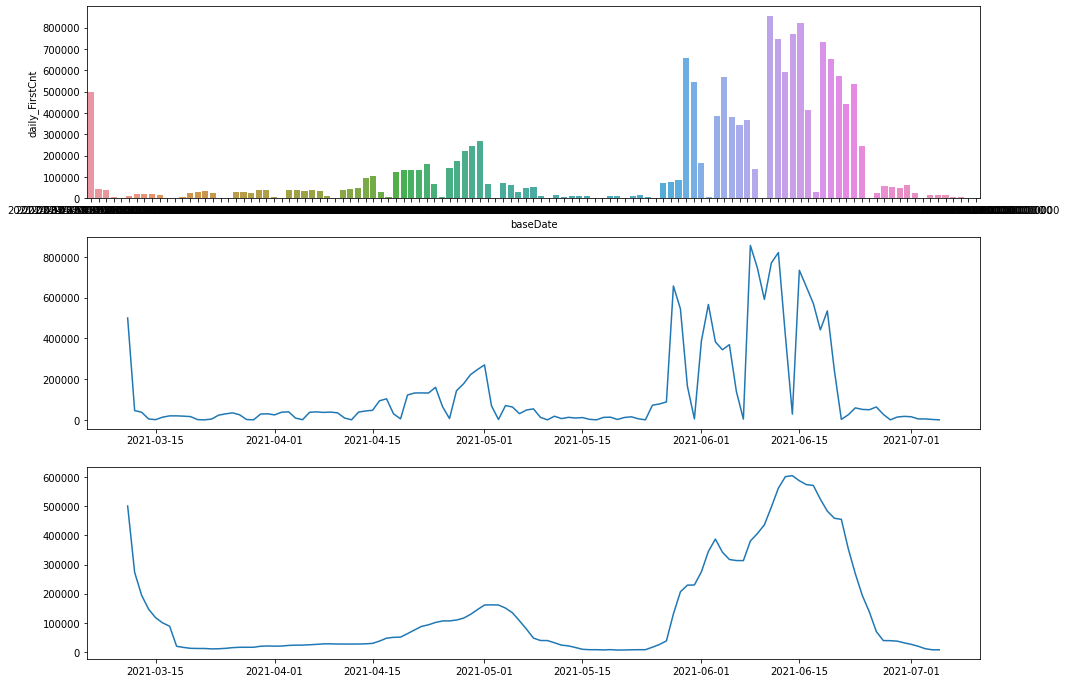

In [51]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 12))
plt.subplot(3, 1, 1)
sns.barplot(data=vacc_kor, x="baseDate",y='daily_FirstCnt')
axs[1].plot(vacc_kor.baseDate, vacc_kor.daily_FirstCnt)
axs[2].plot(vacc_kor_smoothed.index, vacc_kor_smoothed.daily_FirstCnt)

In [52]:
peaks = find_peaks_cwt(vacc_kor_smoothed["daily_FirstCnt"].to_numpy(),
                       widths=np.ones(vacc_kor_smoothed["daily_FirstCnt"].to_numpy().shape)*2)
vacc_kor_smoothed.iloc[peaks]

,daily_FirstCnt,daily_SecondCnt
baseDate,,
2021-03-12,273138.500000,0.000000
2021-03-31,21227.142857,955.285714
2021-04-09,28513.857143,4611.571429
2021-04-24,101789.000000,5455.714286
2021-05-03,161425.142857,18797.714286
2021-06-03,387321.285714,29687.000000
2021-06-14,604513.428571,103478.142857
2021-06-21,454919.714286,149116.714286


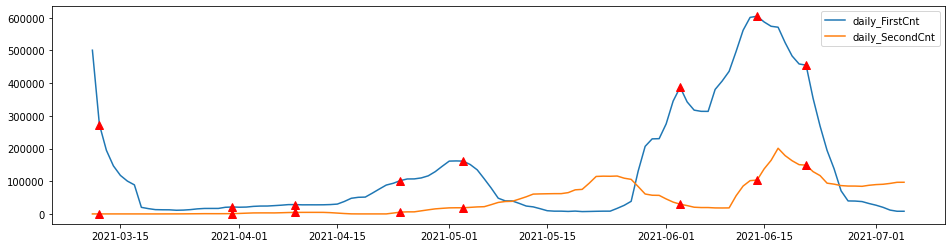

In [54]:
plt.figure(figsize=(16, 4))
plt.plot(vacc_kor_smoothed)
plt.plot(vacc_kor_smoothed.iloc[peaks], "r^", ms=8)
plt.legend(['daily_FirstCnt','daily_SecondCnt'])
plt.show()

# 재난문자

In [58]:
msg_total = pd.read_csv('./safety_msg_crawling_total.csv',engine ='python')

In [59]:
msg_total["create_date"] = pd.to_datetime(msg_total["create_date"])

In [61]:
msg_total = msg_total[msg_total["create_date"] >= "2021-03-11 00:00:00"]
msg_total.tail()

,create_date,location_id,location_name,md101_sn,msg,send_platform
13627,2021-03-11 08:03:34,197,전라남도 장흥군,97024.0,[장흥군청] 장흥8번 확진자는 2월 하순부터 이상증세가 있었으나 진료소를 오지 않았...,cbs
13628,2021-03-11 08:03:07,190,전라남도 순천시,97023.0,"[순천시청]순천만외식1번가(덕월동) 3/8(월)12:50~13:35, 3/10(수)...",cbs
13629,2021-03-11 08:01:48,190,전라남도 순천시,97022.0,[순천시청]순천250번 확진자 발생(경기도거주자로 순천 방문 중 확진). 타지역 방...,cbs
13630,2021-03-11 07:36:30,197,전라남도 장흥군,97021.0,"[장흥군청]어젯밤(3.10) 장흥8,9번 부부확진자 발생\n안양면 요양시설 근무자로...",cbs
13631,2021-03-11 00:16:49,233,충청남도 예산군,97020.0,"[예산군청]예산 25번 확진자 1명 발생(도봉구 914번 관련, 자가격리 중 확진)...",cbs


In [63]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 900)

In [112]:
vacc_encouragement = msg_total[msg_total["msg"].str.contains("백신")]
# vacc_encouragement[vacc_encouragement['msg'].drop(['백신Song'|'마스크'|'확진자'])]
vacc_encouragement        

,create_date,location_id,location_name,md101_sn,msg,send_platform
25,2021-07-01 18:23:03,33,경기도 성남시,110624.0,"[성남시청]우리의 일상을 되찾는 첫걸음, 백신Song과 함께 하나된 성남으로 시련을 이겨내고 일상을 되찾읍시다 https://youtu.be/0XJBfvAJqLs",cbs
191,2021-06-30 16:30:17,179,전라남도 전체,110458.0,[전남도청] 거리두기 1단계 적용(7.1~14) √사적모임 8명까지 √종교활동 좌석 수 50%이내 허용 ▲1차백신접종 2주경과자는 종교시설 등에서 식사 가능합니다,cbs
277,2021-06-29 18:30:55,187,전라남도 목포시,110372.0,[목포시청] 7.1~14▲8명까지 사적모임 가능▲종교시설 좌석수 50%까지 이용가능▲영업시간 제한없음▲백신접종자 경로당에서 식사 가능▲방역수칙 준수 바랍니다,cbs
306,2021-06-29 16:43:23,179,전라남도 전체,110343.0,[전남도청] 종교시설 주관 모임·식사 금지 √목욕장·실내체육시설 음식섭취 금지(1차백신접종 2주경과자는 종교시설·경로당 등에서 식사 허용) ▲방역수칙 준수하세요.,cbs
426,2021-06-28 13:59:52,119,부산광역시 전체,110223.0,"[부산]코로나19 백신접종 여부와 관계없이 마스크 착용은 모두가 지켜야 할 의무입니다. 행사,해수욕장 등 실외 다중밀집 공간에서도 마스크 착용해 주시기 바랍니다.",cbs
515,2021-06-27 10:51:29,231,충청남도 아산시,110134.0,"[아산시청] 6월26일 확진자 3명(아산 717~719번, 가족감염 1, 감염경로조사중 1, 백신산업 1) / 불필요한 모임과 수도권 방문자제 바랍니다.",cbs
575,2021-06-26 15:34:59,67,경상남도 창녕군,110074.0,[창녕군청]6.26(토) 확진자 3명 발생(창녕171~173번/외국인) ▷실내외 마스크착용(백신접종자 포함) ▷유증상시 코로나19 검사바랍니다.,cbs
703,2021-06-25 09:16:23,67,경상남도 창녕군,109946.0,[창녕군청]6.25(금) 확진자 3명 발생(창녕167~169번/외국인)▷마스크착용(백신접종자 포함)▷유증상시 코로나19 검사바랍니다.,cbs
763,2021-06-24 11:35:17,67,경상남도 창녕군,109886.0,[창녕군청]6.24(목) 확진자 6명 발생(창녕161~166번/외국인)▷마스크착용(백신접종자 포함)▷유증상시 코로나19 검사바랍니다.,cbs
856,2021-06-23 14:36:44,67,경상남도 창녕군,109793.0,[창녕군청]6.23(수) 확진자 2명 발생(창녕159~160번/외국인)▷마스크착용(백신접종자 포함)▷유증상시 코로나19 검사바랍니다.,cbs


 *제외 단어: 백신Song,마스크,확진자
 - [밀양시청] 코로나 방역에 가장 큰 백신은 마스크 착용입니다. 반드시 일상생활에서 마스크 착용을 생활화 해주시고 개인 방역수칙을 준수하여 주시기 바랍니다.
 - [성남시청]우리의 일상을 되찾는 첫걸음, 백신Song과 함께 하나된 성남으로 시련을 이겨내고 일상을 되찾읍시다 https://youtu.be/0XJBfvAJqLs	
 - [부산]코로나19 백신접종 여부와 관계없이 마스크 착용은 모두가 지켜야 할 의무입니다. 행사,해수욕장 등 실외 다중밀집 공간에서도 마스크 착용해 주시기 바랍니다.		

In [79]:
vacc_encouragement = vacc_encouragement.drop(["location_id", "location_name", "md101_sn", "msg", "send_platform"], axis=1)

In [80]:
vacc_encouragement = vacc_encouragement.reset_index(drop=True)

In [82]:
vacc_encouragement.tail()

,create_date
558,2021-03-19 09:00:09
559,2021-03-18 19:34:39
560,2021-03-18 19:00:02
561,2021-03-15 07:53:38
562,2021-03-11 09:54:29


In [84]:
vcc_msg_sent = vacc_encouragement.groupby(vacc_encouragement["create_date"].dt.date).count()
vcc_msg_sent.columns = ["amount"]
vcc_msg_sent.reset_index(inplace=True)
vcc_msg_sent["create_date"] = pd.to_datetime(vcc_msg_sent["create_date"])
vcc_msg_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   create_date  76 non-null     datetime64[ns]
 1   amount       76 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [85]:
vcc_msg_sent

,create_date,amount
0,2021-03-11,1
1,2021-03-15,1
2,2021-03-18,2
3,2021-03-19,19
4,2021-03-20,1
5,2021-03-22,23
6,2021-03-23,18
7,2021-03-24,18
8,2021-03-25,12
9,2021-03-26,17


### 평활화

In [86]:
vcc_msg_sent_smoothed = vcc_msg_sent.rolling(7, min_periods=1).mean()
vcc_msg_sent_smoothed.index = vcc_msg_sent["create_date"]
vcc_msg_sent_smoothed

,amount
create_date,
2021-03-11,1.000000
2021-03-15,1.000000
2021-03-18,1.333333
2021-03-19,5.750000
2021-03-20,4.800000
2021-03-22,7.833333
2021-03-23,9.285714
2021-03-24,11.714286
2021-03-25,13.285714


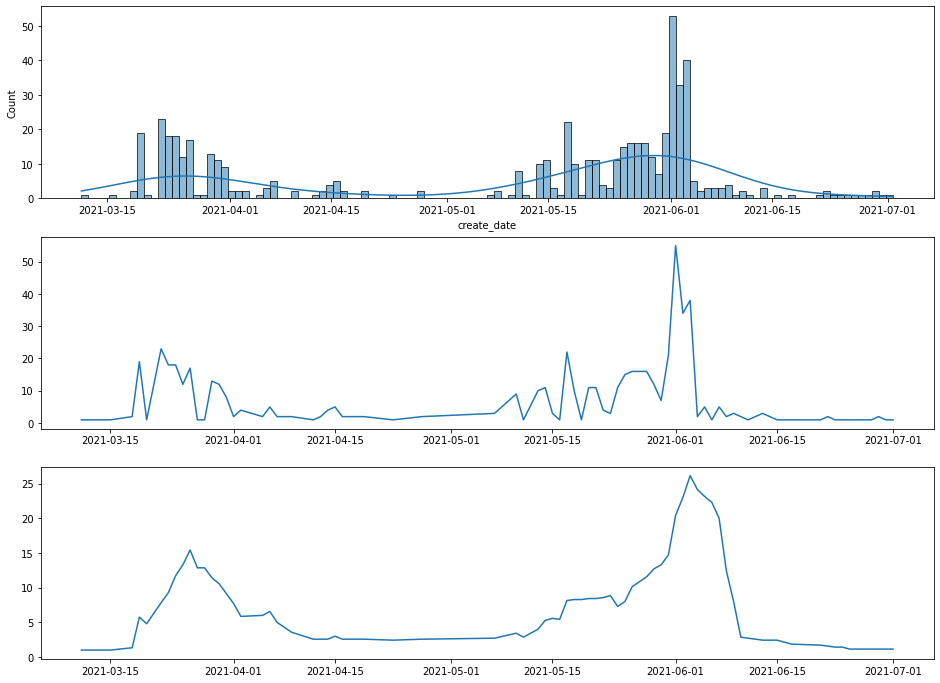

In [87]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(16, 12))
plt.subplot(3, 1, 1)
sns.histplot(data=vacc_encouragement, x="create_date", bins=116, kde=True)
axs[1].plot(vcc_msg_sent.create_date, vcc_msg_sent.amount)
# 3번째: smoothing 한 후 데이터 그리기
axs[2].plot(vcc_msg_sent_smoothed.index, vcc_msg_sent_smoothed.amount)

In [88]:
peaks = find_peaks_cwt(vcc_msg_sent_smoothed["amount"].to_numpy(),
                       widths=np.ones(vcc_msg_sent_smoothed["amount"].to_numpy().shape)*2)
vcc_msg_sent_smoothed.iloc[peaks]

,amount
create_date,
2021-03-26,15.428571
2021-05-19,8.285714
2021-06-05,23.142857
2021-06-30,1.142857


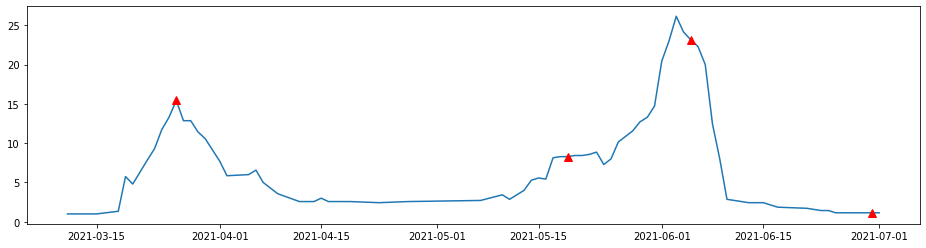

In [89]:
plt.figure(figsize=(16, 4))
plt.plot(vcc_msg_sent_smoothed)
plt.plot(vcc_msg_sent_smoothed.iloc[peaks], "r^", ms=8)

# 재난문자 발송량과 백신접종자수 그래프

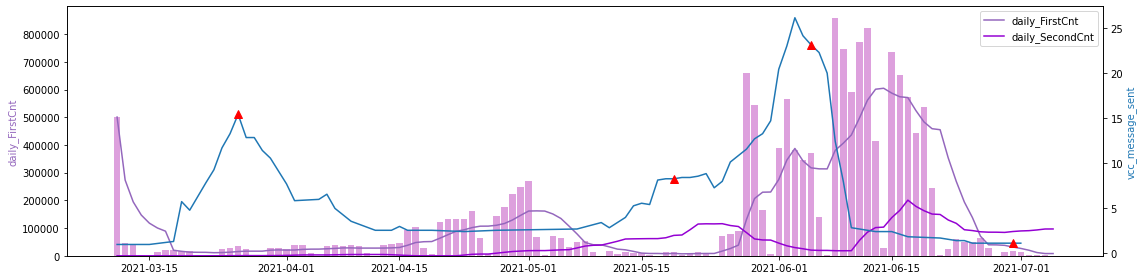

In [111]:
fig, ax1 = plt.subplots(figsize=(16, 4))

color = "tab:purple"
ax1.set_ylabel("daily_FirstCnt", color=color)
ax1.plot(vacc_kor_smoothed.index,vacc_kor_smoothed.daily_FirstCnt, 
         label='daily_FirstCnt',color=color)
ax1.plot(vacc_kor_smoothed.index,vacc_kor_smoothed.daily_SecondCnt, 
         label='daily_SecondCnt',color='darkviolet')
ax1.bar(vacc_kor.baseDate, vacc_kor.daily_FirstCnt, color="plum")

plt.legend()

ax2 = ax1.twinx()
color= "tab:blue"
ax2.set_ylabel("vcc_message_sent", color=color)
ax2.plot(vcc_msg_sent_smoothed, color=color)
ax2.plot(vcc_msg_sent_smoothed.iloc[peaks], "r^", ms=8)

fig.tight_layout()